In [1]:
from models.denseautoencoder import DenseAutoencoder
from utils.loaders import SigGenDataset
from utils.trainers import BaseTrainer
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.datasets import make_classification
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob

Epoch: 0/9
-----------------------------
Loss avg: 9.497253866328493e-05
Time : 0.47487601172178984
Epoch: 1/9
-----------------------------
Loss avg: 9.87617023895382e-07
Time : 0.46817391365766525
Epoch: 2/9
-----------------------------
Loss avg: 8.334201041293454e-07
Time : 0.46767709497362375
Epoch: 3/9
-----------------------------
Loss avg: 8.228534568388568e-07
Time : 0.4684671610593796
Epoch: 4/9
-----------------------------
Loss avg: 9.491565428731974e-07
Time : 0.46826400235295296
Epoch: 5/9
-----------------------------
Loss avg: 1.4598170274382483e-06
Time : 0.46599237620830536
Epoch: 6/9
-----------------------------
Loss avg: 1.0334772284181782e-06
Time : 0.46811274252831936
Epoch: 7/9
-----------------------------
Loss avg: 8.379958671866916e-07
Time : 0.46774232666939497
Epoch: 8/9
-----------------------------
Loss avg: 7.145339495195913e-07
Time : 0.4678251454606652
Epoch: 9/9
-----------------------------
Loss avg: 7.046720632786218e-07
Time : 0.4664518339559436
Ti

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster Accuracy: 0.27


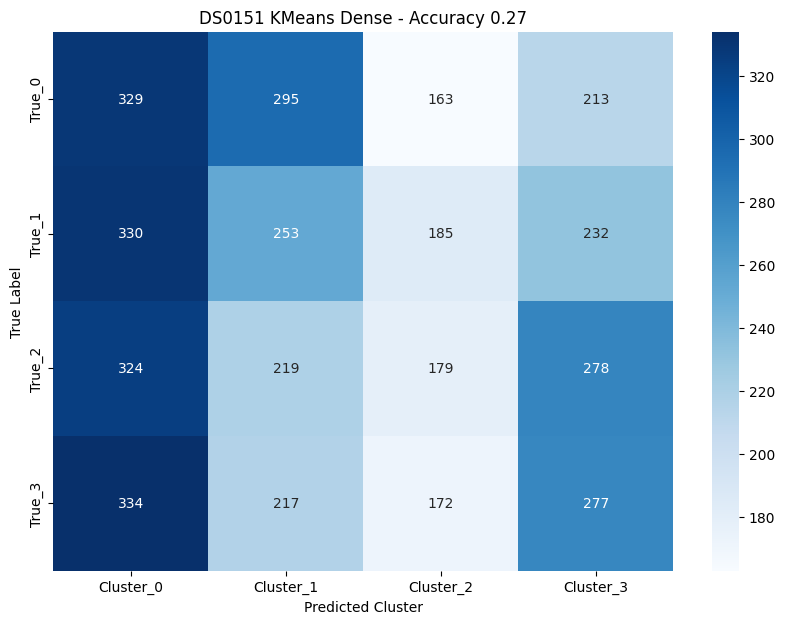

In [6]:
ds_name_array = ['DS0151',
                 'DS0612',
                 'DS0652',
                 'DS1153',
                 'DS1193',
                 'DS1654',
                 'DS1694',
                 'DS2155',
                 'DS2656',
                 'DS3157']

for ds_name in ds_name_array:
    model = DenseAutoencoder(input_size=5000,latent_dim=128).to("cuda")
    filepaths = [f'./SigGen/{ds_name}_G13000771.mat',
             f'./SigGen/{ds_name}_G13000773.mat',
             f'./SigGen/{ds_name}_G13000774.mat',
             f'./SigGen/{ds_name}_G13000775.mat']
    dataset = SigGenDataset(filepaths, transform = True)
    trainers = BaseTrainer(model)
    
    model = trainers._train(train_loader = dataset, num_epochs = 10, loss_function=torch.nn.MSELoss())
    # model.load_state_dict(torch.load(f"{ds_name}_cnn_weights.pt"))
    torch.save(model.state_dict(), f"{ds_name}_dense_weights.pt")
    
    latent, target = trainers.extract_latent(dataset)
    
    # latent_reshape = latent.reshape((latent.shape[0], latent.shape[1]*latent.shape[2]))
    
    # Initialize and fit k-Means clustering
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(latent)

    # Create a confusion matrix to evaluate clustering performance
    # We need to compute a mapping between cluster labels and true labels
    # First, create a confusion matrix to find out how clusters are mapped to true labels
    conf_matrix = confusion_matrix(target, clusters)

    # Find the optimal permutation of cluster labels to match true labels
    from scipy.optimize import linear_sum_assignment

    # Solve the linear sum assignment problem
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)

    # Re-map clusters to the true labels
    cluster_to_label = dict(zip(col_ind, row_ind))

    # Map clusters to labels
    y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in clusters])

    # Compute accuracy
    accuracy = accuracy_score(target, y_pred_mapped)
    print(f"Cluster Accuracy: {accuracy:.2f}")
    
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=[f'True_{i}' for i in range(conf_matrix.shape[0])],
                              columns=[f'Cluster_{i}' for i in range(conf_matrix.shape[1])])


    # Plot the confusion matrix using a heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{ds_name} KMeans Dense - Accuracy {accuracy:.2f}')
    plt.xlabel('Predicted Cluster')
    plt.ylabel('True Label')

    file_path = os.path.join('confusion_matrix', f"{ds_name}_confusion_matrix_heatmap_dense.png")

    plt.savefig(file_path, dpi=300)

    plt.show()
    break